<h1 align="center"> Principals of Biomedical Engineering </h1>
<h3 align="center"> Dr. M. Jahed </h3>
<br>
<h2 align="center"> EMG Classificatioh </h2>
<br>
<h4 align="center">Mohammad Hossein Shafieizadegan</h4>
<h4 align="center">Navid Bagheri Shouraki</h4>

# Add Required packages

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import find_peaks

# Load Data

Load the dataset, whether our own acquired data or online free available dataset

In [2]:
data = scipy.io.loadmat('../Data/DB2_s13/S13_E1_A1.mat')

import os

# Specify the directory path
directory = '../Results/Sub-13'

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully")
else:
    print("Directory already exists")

Directory created successfully


### Data Visualization

In [3]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Jan 14 06:18:45 2013',
 '__version__': '1.0',
 '__globals__': [],
 'emg': array([[-1.0970531e-06,  2.3992186e-06, -1.2331418e-06, ...,
          3.0030355e-05, -4.1083999e-06, -9.1997499e-06],
        [ 1.0848232e-06,  5.0844646e-06, -5.4754637e-06, ...,
          2.5025232e-05, -1.9256686e-06, -4.9593687e-06],
        [ 4.1059461e-06,  5.5876708e-06, -3.8888552e-06, ...,
          1.7158160e-05, -2.4285234e-06, -7.4180512e-06],
        ...,
        [-6.5556083e-07, -6.3960965e-07,  6.7698975e-06, ...,
         -5.7966588e-04, -1.0254973e-05, -9.9073295e-06],
        [ 1.6930003e-06,  3.1846763e-08,  3.8756666e-06, ...,
         -7.0359609e-05, -1.0255813e-05, -2.8595960e-06],
        [ 1.9924594e-06,  3.6760775e-07,  2.3496375e-06, ...,
         -4.1870106e-05, -1.1095899e-05,  2.3896791e-06]], dtype=float32),
 'acc': array([[-0.06232772,  0.9217136 ,  0.36302575, ...,  0.5906803 ,
         -0.3089123 ,  0.535151

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])

In [5]:
data['exercise'][0]

array([1], dtype=uint8)

In [6]:
data['stimulus'][0:2000]

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int8)

In [7]:
set(data['stimulus'].reshape(-1))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

### Dataset variables
For each exercise, for each subject, the database contains one matlab file with synchronized variables. The variables included in the matlab files are:
- Subject: subject number.
- Exercise: exercise number.
- Emg (12 columns): sEMG signal. Columns 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. Columns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis, while columns 11 and 12 contain signals from the main activity spot of the muscles biceps brachii and triceps brachii.
- Acc (36 columns): three-axes accelerometers of the 12 electrodes.
- Glove (22 columns): uncalibrated signal from the 22 sensors of the cyberglove.
The cyberglove signal corresponds to raw data from the cyberglove sensors, which are expected to be proportional to the angles at the joints.
- Stimulus (1 column): the movement repeated by the subject, according to the displayed movie.
- Restimulus (1 column): again the movement repeated by the subject, but with the duration of the movement label refined a-posteriori in order to better correspond to the real movement.
Read the paper Gijsberts et al., 2014 for more details about relabelling procedure.
- Repetition (1 column): repetition of the stimulus.
- Rerepetition (1 column): repetition of restimulus.
- Force (6 columns): force recorded during the third exercise
- forcecal (2 x 6 values): the force sensors calibration values, corresponding to the minimal and the maximal force.


In [8]:
emg_data = np.array(data['emg']).transpose()
stimulus = data['stimulus']

In [9]:
emg_data.shape

(12, 1801392)

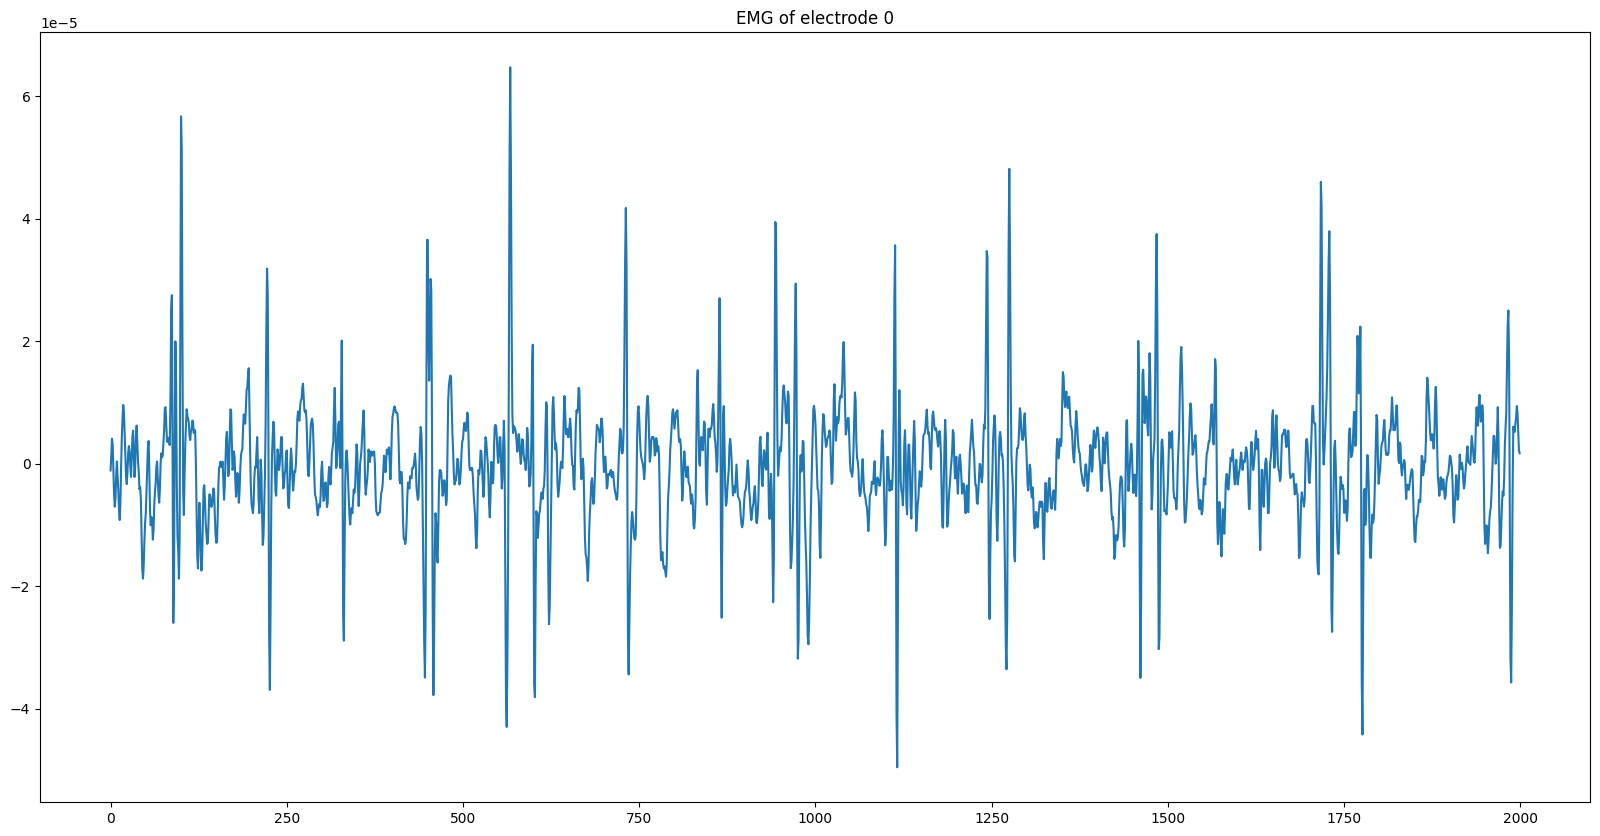

In [10]:
idx = 0
fs = 2000

plt.figure(figsize=(20,10))
plt.plot(emg_data[idx, 0:fs])
plt.title(f"EMG of electrode {idx}")
plt.savefig(f'{directory}/EMG_elec{idx}.png')
plt.show()

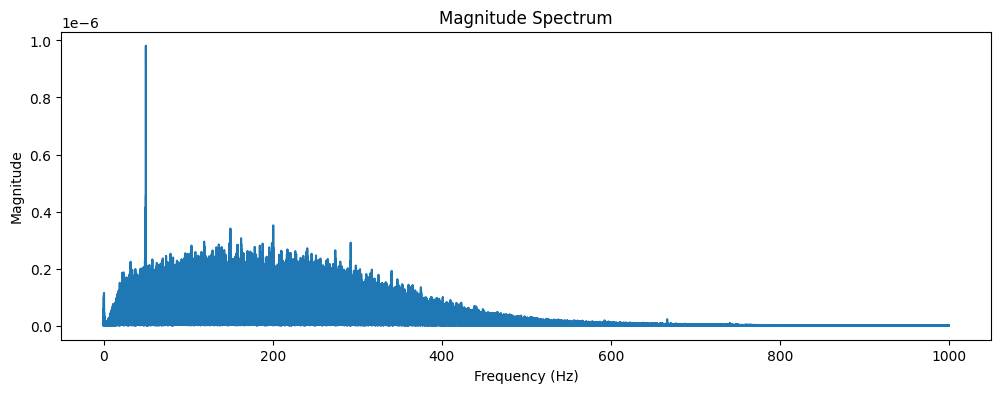

In [11]:
# plot the magnitude spectrum
plt.figure(figsize=(12, 4))
plt.magnitude_spectrum(emg_data[idx, :], Fs=fs)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')
plt.savefig(f'{directory}/FFT_elec{idx}.png')
plt.show()

# Signal Preprocessing

The following steps must be done:
- Bandpass Filtering
- Notch filter
- Z-score

### Bandpass filtering

We will utilize a bandpass filter regarding the frequency range of EMG signals

In [12]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

In [13]:
fs = 2000
f_low = 20
f_high = 200

emg_signal_bandpass = []
for i in range(emg_data.shape[0]):
    emg_signal_bandpass.append(butter_bandpass_filter(emg_data[i, :], f_low, f_high, fs))
emg_signal_bandpass = np.array(emg_signal_bandpass)

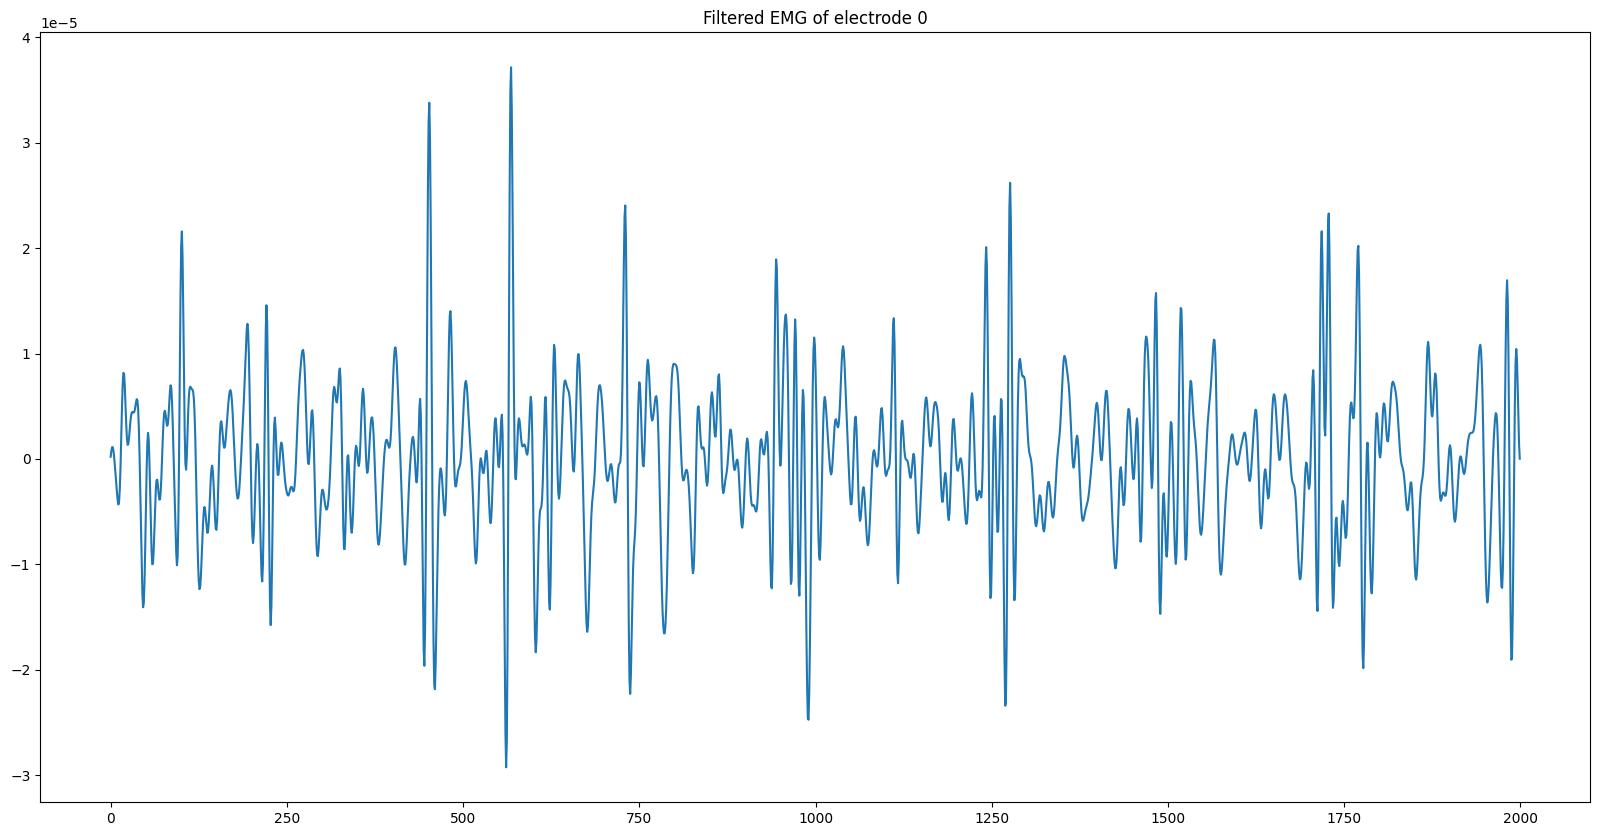

In [14]:
plt.figure(figsize=(20,10))
plt.plot(emg_signal_bandpass[idx, 0:fs])
plt.title(f"Filtered EMG of electrode {idx}")
plt.savefig(f'{directory}/EMG_filtered_elec{idx}.png')
plt.show()

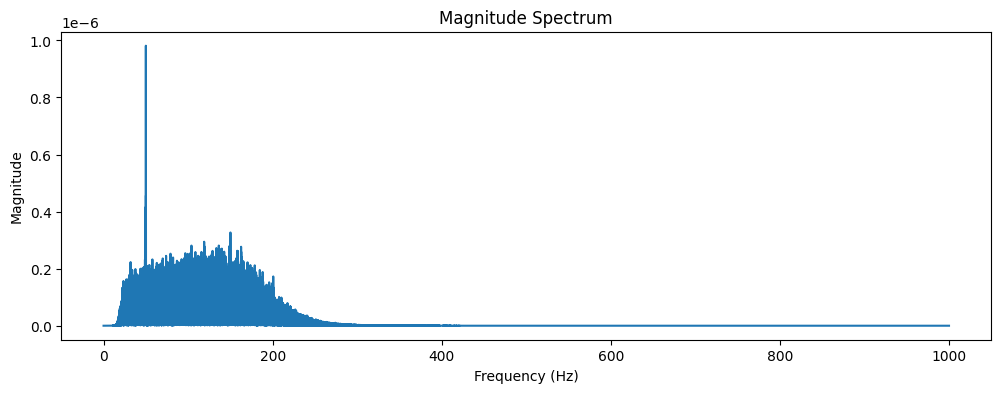

In [15]:
# plot the magnitude spectrum
plt.figure(figsize=(12, 4))
plt.magnitude_spectrum(emg_signal_bandpass[idx, :], Fs=2000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')
plt.savefig(f'{directory}/EMG_filtered_fft_elec{idx}.png')
plt.show()

### Notch filter
Applying `50 Hz` notch filter

In [16]:
def notch_filter(data, notch_freq, fs, Q=30):
    nyq = 0.5 * fs
    f0 = notch_freq / nyq
    b, a = iirnotch(f0, Q)
    y = filtfilt(b, a, data)
    return y

In [17]:
notch_freq = 50
emg_signal_notch = notch_filter(emg_signal_bandpass, notch_freq, fs)

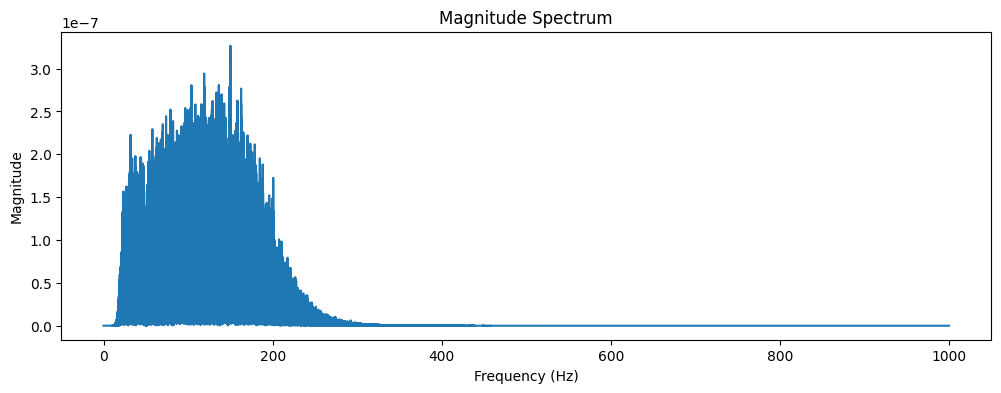

In [18]:
# plot the magnitude spectrum
plt.figure(figsize=(12, 4))
plt.magnitude_spectrum(emg_signal_notch[0], Fs=2000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')
plt.savefig(f'{directory}/EMG_notch_fft_elec{idx}.png')
plt.show()

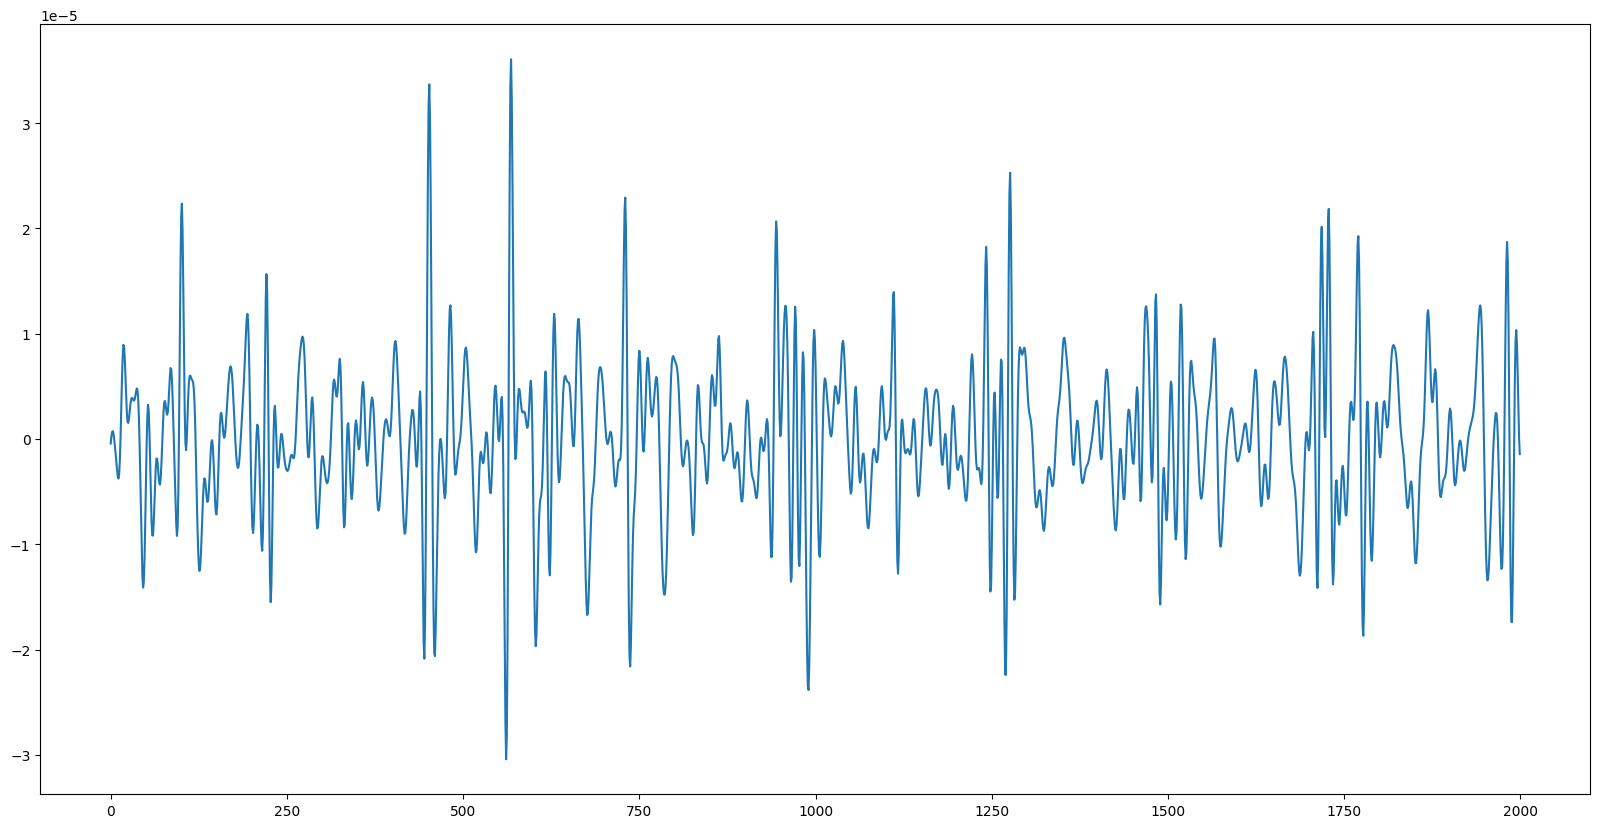

In [19]:
plt.figure(figsize=(20,10))
plt.plot(emg_signal_notch[0][0:fs])
plt.savefig(f'{directory}/EMG_notch_elec{idx}.png')
plt.show()

### Z-score normalization

In [20]:
# Step 3: Z-score normalization
scaler = StandardScaler()
emg_signal_normalized = scaler.fit_transform(emg_signal_notch)

data_prep = emg_signal_normalized

# Signal Windowing

In [21]:
from collections import Counter

def window_signal(emg_signal, window_length, window_step, stimulus):
    windows = []
    labels = []
    num_samples = emg_signal.shape[1]

    for start in range(0, num_samples - window_length + 1, window_step):
        end = start + window_length

        # Extract window of the signal
        windowed_signal = emg_signal[:, start:end]  # Extract along the first dimension
        label = Counter(stimulus[start:end].reshape(-1)).most_common(1)[0][0]

        windows.append(windowed_signal)
        labels.append(label)

    windows = np.stack(windows, axis=2)  # Stack the windows along the third dimension

    return windows, labels

window_length = round(0.2 * fs)
window_step = round(0.01 * fs)
signal_windows, window_labels = window_signal(data_prep, window_length, window_step, stimulus)

In [22]:
signal_windows.shape

(12, 400, 90050)

# Feature Extraction

Recommended features:
- Mean absolute value (MAV)
- Standard deviation (STD)
- Variance (VAR)
- Waveform length (WL)
- Zero crossing (ZC)
- Root mean square (RMS)
- Number of peaks (NP)
- Slope sign change (SSC)
- Correlation coefficient (Cor)
- Integrated absolute value (IAV)

#### Defining each feature

In [23]:
def mean_absolute_value(signal):
    return np.mean(np.abs(signal))

def standard_deviation(signal):
    return np.std(signal)

def variance(signal):
    return np.var(signal)

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def zero_crossing(signal):
    return np.sum(np.diff(np.sign(signal)) != 0)

def root_mean_square(signal):
    return np.sqrt(np.mean(np.square(signal)))

def number_of_peaks(signal):
    peaks, _ = find_peaks(signal)
    return len(peaks)

def slope_sign_change(signal):
    return np.sum(np.diff(np.sign(np.diff(signal))) != 0)

def correlation_coefficient(signal1, signal2):
    return np.corrcoef(signal1, signal2)[0, 1]

def integrated_absolute_value(signal):
    return np.sum(np.abs(signal))

### Applying these features to the dataset

In [24]:
def calculate_features_for_windows(signal_windows):
    num_windows = signal_windows.shape[2]
    num_features = 10  # Assuming 10 features are calculated
    num_channels = signal_windows.shape[0]

    features = np.zeros((num_windows, num_features, num_channels))

    for i in range(num_windows):
        for j in range(num_channels):
            window = signal_windows[j, :, i]
            
            mav = mean_absolute_value(window)
            std = standard_deviation(window)
            var = variance(window)
            wl = waveform_length(window)
            zc = zero_crossing(window)
            rms = root_mean_square(window)
            npk = number_of_peaks(window)
            ssc = slope_sign_change(window)
            cor = correlation_coefficient(window, window) 
            iav = integrated_absolute_value(window)

            features[i, :, j] = [mav, std, var, wl, zc, rms, npk, ssc, cor, iav]

    # Reshape features array to match desired column shape
    features_reshaped = features.reshape(num_windows, -1)
    
    # Create a DataFrame from the reshaped features array
    feature_names = ['MAV', 'STD', 'VAR', 'WL', 'ZC', 'RMS', 'NP', 'SSC', 'Cor', 'IAV']
    columns = [f'Channel{j+1}_{col}' for j in range(num_channels) for col in feature_names]
    features_df = pd.DataFrame(features_reshaped, columns=columns)

    return features_df

In [25]:
features = calculate_features_for_windows(signal_windows)

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

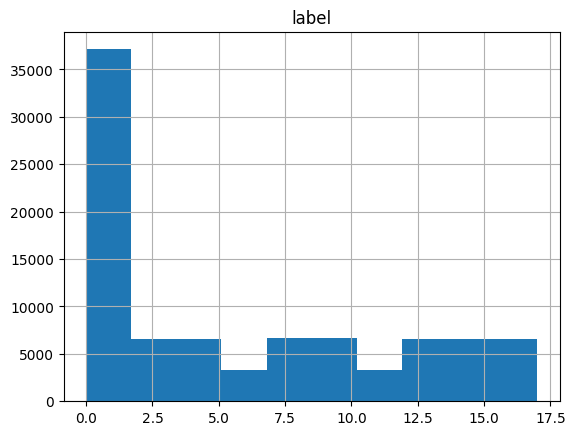

In [26]:
STIM_df = pd.DataFrame(window_labels, columns=['label'])
data_df = pd.concat([features, STIM_df], axis=1)
STIM_df.hist()

### It can be seen that the rest stimulus (label = 0) has imbalanced our data set. Regarding the fact that we don't want to classify the rest stimulus, we will remove it from dataset

In [27]:
no_rest_data_df = data_df[data_df['label'] != 0]
no_rest_data_df

,Channel1_MAV,Channel1_STD,Channel1_VAR,Channel1_WL,Channel1_ZC,Channel1_RMS,Channel1_NP,Channel1_SSC,Channel1_Cor,Channel1_IAV,...,Channel12_STD,Channel12_VAR,Channel12_WL,Channel12_ZC,Channel12_RMS,Channel12_NP,Channel12_SSC,Channel12_Cor,Channel12_IAV,label
331,0.515060,0.390652,0.471868,0.310114,0.410045,0.696874,0.752267,1.356221,0.518278,1.796395,...,124.045757,164.018038,278.749682,300.906741,542.488529,207.311367,718.558003,272.634222,341.361676,1
332,0.488845,0.398306,0.468998,0.304301,0.406603,0.717662,0.782944,1.360500,0.522464,1.793865,...,121.720262,162.641141,287.064666,313.177793,544.200187,208.985466,717.545802,254.337644,347.762096,1
333,0.478391,0.411778,0.462300,0.318238,0.396446,0.775304,0.787727,1.344745,0.529471,1.782670,...,127.295135,158.578482,310.121475,315.090929,537.898073,211.788494,713.068028,251.691815,350.490180,1
334,0.478142,0.423685,0.480526,0.329182,0.411051,0.796140,0.753009,1.378113,0.533238,1.764509,...,131.672994,164.420223,318.455953,301.203464,551.245251,213.295312,705.803495,254.864791,337.901943,1
335,0.502756,0.415550,0.479357,0.333576,0.422473,0.827958,0.730915,1.437472,0.546013,1.685218,...,133.430322,168.989050,331.183065,292.366056,574.988744,218.405067,674.087321,259.848728,328.281111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90045,0.297823,0.285804,0.316806,0.284572,0.298882,0.391661,0.358136,0.328295,0.300518,3.142300,...,113.828928,119.552819,156.664581,143.254384,131.317885,120.207026,1256.919988,192.641642,138.321096,17
90046,0.299552,0.288627,0.318003,0.286064,0.298690,0.393943,0.346608,0.322303,0.304812,3.144790,...,114.425530,119.476132,157.577249,138.643132,128.921167,121.924785,1257.916106,191.139252,138.978978,17
90047,0.300013,0.288636,0.317375,0.283789,0.299756,0.389949,0.346586,0.315819,0.304019,3.154436,...,113.515477,119.902226,155.979699,138.634557,126.327533,121.607732,1261.774295,188.459312,137.620076,17
90048,0.300321,0.290637,0.320436,0.284609,0.301363,0.393934,0.343632,0.316226,0.305968,3.149238,...,113.843668,120.545212,157.573404,137.452722,126.490488,122.387130,1259.695051,189.974816,139.067995,17


# Classification and model training

### Split the dataset into train and test set

In [28]:
y = no_rest_data_df['label']
X = no_rest_data_df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train

,Channel1_MAV,Channel1_STD,Channel1_VAR,Channel1_WL,Channel1_ZC,Channel1_RMS,Channel1_NP,Channel1_SSC,Channel1_Cor,Channel1_IAV,...,Channel12_MAV,Channel12_STD,Channel12_VAR,Channel12_WL,Channel12_ZC,Channel12_RMS,Channel12_NP,Channel12_SSC,Channel12_Cor,Channel12_IAV
71068,0.485868,0.472253,0.478075,0.698212,0.302659,0.319311,0.854343,1.021418,0.663164,2.178046,...,191.230002,279.284860,121.063773,127.724330,341.737046,408.567176,265.265601,871.218314,151.533097,135.983790
23508,0.691567,0.355132,0.396950,0.332621,0.308785,0.351822,0.643881,0.908612,0.534016,2.517500,...,158.779865,133.048373,123.513816,140.728905,257.552448,363.444669,213.606535,1006.999826,136.205277,134.763601
44709,0.439294,0.318451,0.490622,0.329500,0.350940,0.318201,0.493052,0.603202,0.435715,1.551443,...,196.248848,131.800042,140.376034,127.280496,197.220995,241.280904,174.285958,620.577241,873.262017,159.811185
19254,0.455141,0.412144,0.373172,0.438847,0.322316,0.402891,0.506908,0.786430,0.355368,2.725920,...,149.268973,175.538810,128.926502,161.156511,202.763313,314.571829,142.147211,1090.368066,191.904573,147.795713
79403,0.400150,0.446572,0.593470,0.309543,0.403684,0.800391,0.607374,0.711448,0.360543,2.108709,...,237.388079,123.817318,161.473655,320.156461,242.949500,284.579281,144.217011,843.483638,201.423602,407.974636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71904,0.556086,0.417441,0.335436,0.538922,0.319825,0.366805,0.395696,0.797563,0.353360,2.623010,...,134.174486,215.568953,127.929901,146.721937,158.278449,319.025325,141.343916,1049.203865,171.861313,164.965712
87161,1.149113,0.666101,0.516783,0.495973,0.325137,0.311495,0.631661,1.282527,0.542301,1.750262,...,206.713023,198.389219,130.054859,124.598145,252.664387,513.010935,216.920563,700.104619,147.692274,139.238571
61347,0.492895,0.370039,0.397160,0.333651,0.284637,0.278312,0.653533,0.767156,0.407097,2.817853,...,158.863863,133.460363,113.854799,111.324915,261.413325,306.862319,162.838891,1127.141343,125.789126,134.595438
1528,1.035132,0.566897,0.369829,0.354181,0.312766,0.357591,0.579113,1.804971,0.792238,1.428170,...,147.931619,141.672286,125.106272,143.036213,231.645064,721.988260,316.895129,571.267931,147.636059,203.072549


### Train a KNN model

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # Choose the number of neighbors
knn.fit(X_train, y_train)

# Make predictions on the testing data
knn_pred = knn.predict(X_test)

### Train Random Forst model

In [31]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
rf_predictions = rf_classifier.predict(X_test)

### Report the metrices (Confusion matrix)

In [33]:
# Evaluate and report confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{directory}/{title}.png')
    plt.show()

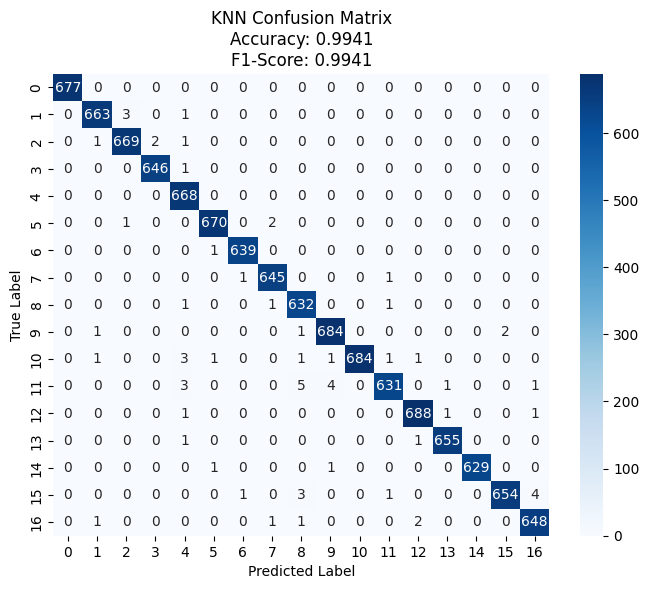

In [34]:
plot_confusion_matrix(y_test, knn_pred, title='KNN Confusion Matrix')

In [35]:
f1_score(y_test, knn_pred, average='micro')

0.9941322901849218

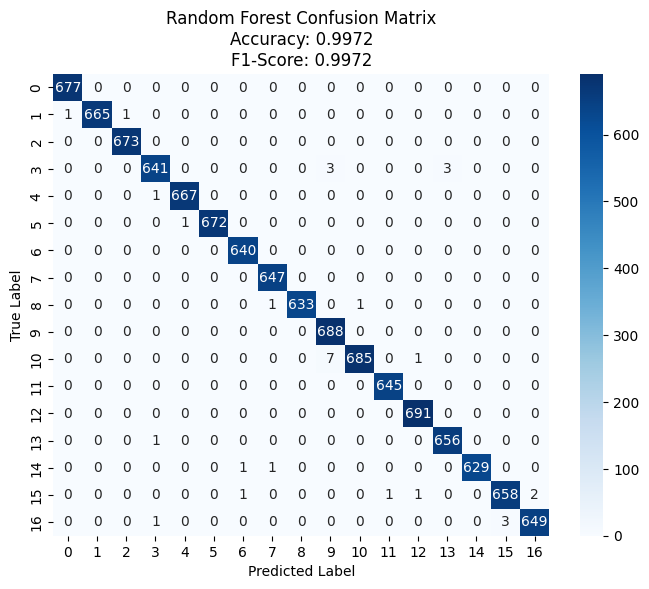

In [36]:
plot_confusion_matrix(y_test, rf_predictions, title='Random Forest Confusion Matrix')

In [37]:
f1_score(y_test, rf_predictions, average='micro')

0.9971550497866287